## M1 dan M4 - Model Prediksi Titik Panas di Sumatera Selatan 2001-2023

In [1]:
# pustaka generate number
import random as rm
import time as tm

# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### Config Models

In [2]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
# # Setting Algorithm
# algorithm = "LSTM-RNN"

In [4]:
# Setting Algorithm
algorithm = "GRU-RNN"

In [5]:
# set parameter
batch_size=4
epochs=1500
activation = "selu"
dropout_rate = 0.25
optimizer = "sgd"

### 1. Akuisisi Data

In [6]:
# Set waktu komputasi
start = tm.time()

In [7]:
# load dataset
dataset = pd.read_csv("dataset/dataset_hotspot.csv", parse_dates=["acq_date"])

In [8]:
# cek informasi dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.4 KB


In [9]:
print(dataset)

      acq_date  hotspot
0   2001-01-31        3
1   2001-02-28        5
2   2001-03-31       10
3   2001-04-30       20
4   2001-05-31       39
..         ...      ...
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42

[276 rows x 2 columns]


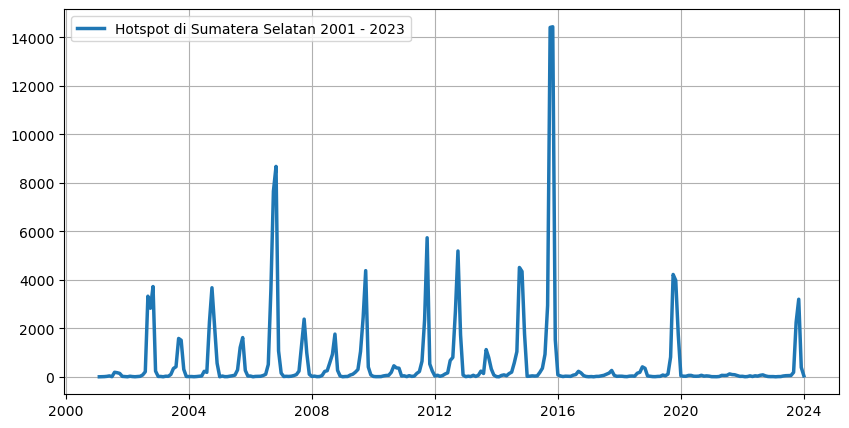

In [10]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 2. PraProses Data

- Seleksi Fitur

In [11]:
# hanya memperhatikan aspek hotspot
data = dataset.filter(["hotspot"])
data = data.values

In [12]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]], dtype=int64)

In [13]:
# cek dimensi normalisasi
data.shape

(276, 1)

- Normalisasi Data

In [14]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.array(data))

In [15]:
# show data train
np.round(scaled[:5],7)

array([[0.       ],
       [0.0001386],
       [0.000485 ],
       [0.0011778],
       [0.0024941]])

In [16]:
# cek dimensi normalisasi
scaled.shape

(276, 1)

- Hasil PraProses Data

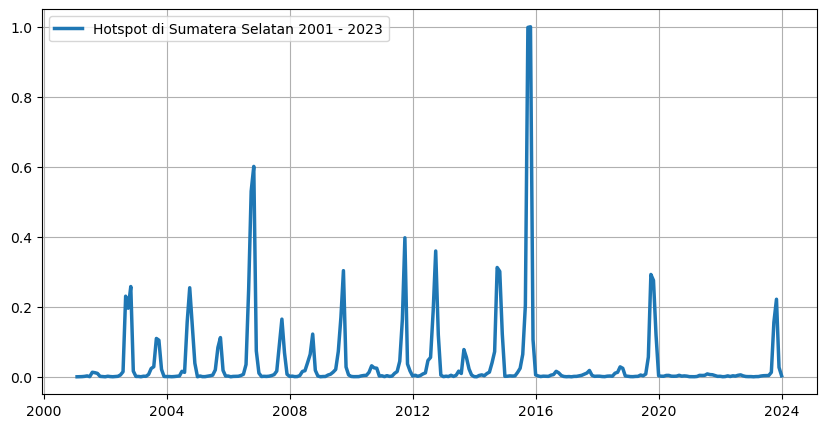

In [17]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], np.array(scaled), color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 3. Pembagian Data

In [18]:
# Data latih th 2001 - 2018 = 216 baris
# Data uji th 2019 - 2023 = 60 baris

In [19]:
# # split data train and test
# train_data, test_data = train_test_split(scaled, train_size=0.80, test_size=0.20, shuffle=False)

In [20]:
# data train
train_size = 216

# set loc data train
train_data = scaled[0:train_size,:]

# show data train
np.round(train_data[:5],7)

array([[0.       ],
       [0.0001386],
       [0.000485 ],
       [0.0011778],
       [0.0024941]])

In [21]:
train_data.shape

(216, 1)

In [22]:
# data test
test_size = 60

# set loc data test
test_data = scaled[train_size:len(scaled),:]

# show data test
np.round(test_data[:5],7)


array([[0.000485 ],
       [0.0003464],
       [0.0010392],
       [0.0012471],
       [0.0049882]])

In [23]:
test_data.shape

(60, 1)

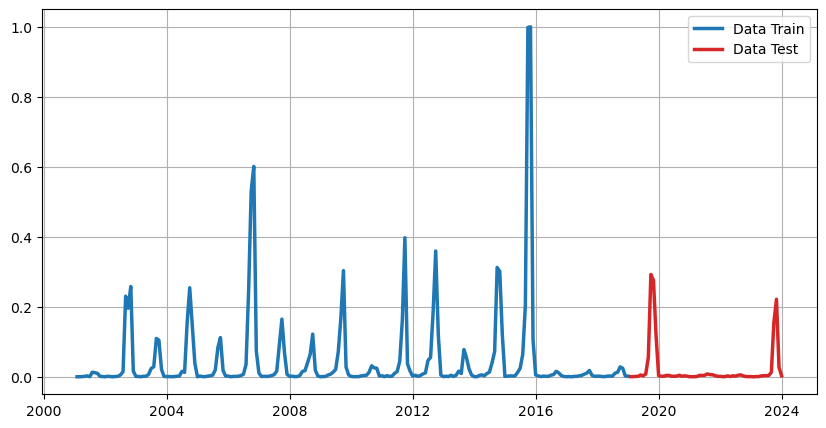

In [24]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:len(train_data),0], train_data, color="tab:blue", label="Data Train", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data):len(dataset),0], test_data, color="tab:red", label="Data Test", linewidth=2.5)

# make are labels
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 4. Supervised Learning

In [25]:
# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [26]:
# set time series lag
look_back = 1

In [27]:
# Proses supervised learning
x_train, y_train = create_dataset(look_back, train_data)
print(x_train.shape, y_train.shape)

(215, 1) (215,)


In [28]:
# Proses supervised learning
x_test, y_test = create_dataset(look_back, test_data)
print(x_test.shape, y_test.shape)

(59, 1) (59,)


- hasil supervised learning

In [29]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
# cek dimensi data
print(x_train.shape, x_test.shape)

(215, 1, 1) (59, 1, 1)


### 5. Model Prediksi Titik Panas

In [31]:
# call function
from class_base_model import lstm_algorithm
from class_base_model import gru_algorithm

# check algorithm
if algorithm == "algorithm":
    # call model LSTM-RNN
    model = lstm_algorithm(x_train, activation, dropout_rate, optimizer)
else:
    # call model GRU-RNN
    model = gru_algorithm(x_train, activation, dropout_rate, optimizer)

# fit network
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1, shuffle=False, use_multiprocessing=False)

Epoch 1/1500
54/54 [==============================] - 11s 25ms/step - loss: 0.0546 - mean_absolute_error: 0.0546 - mean_squared_error: 0.0200 - mean_absolute_percentage_error: 10740.1357 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280 - val_mean_squared_error: 0.0043 - val_mean_absolute_percentage_error: 219128.5781
Epoch 2/1500
54/54 [==============================] - 0s 5ms/step - loss: 0.0532 - mean_absolute_error: 0.0532 - mean_squared_error: 0.0188 - mean_absolute_percentage_error: 61199.6992 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249 - val_mean_squared_error: 0.0042 - val_mean_absolute_percentage_error: 157225.2656
Epoch 3/1500
54/54 [==============================] - 0s 5ms/step - loss: 0.0522 - mean_absolute_error: 0.0522 - mean_squared_error: 0.0178 - mean_absolute_percentage_error: 51599.3906 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0042 - val_mean_absolute_percentage_error: 126941.0234
Epoch 4/1500
54/54 [===============

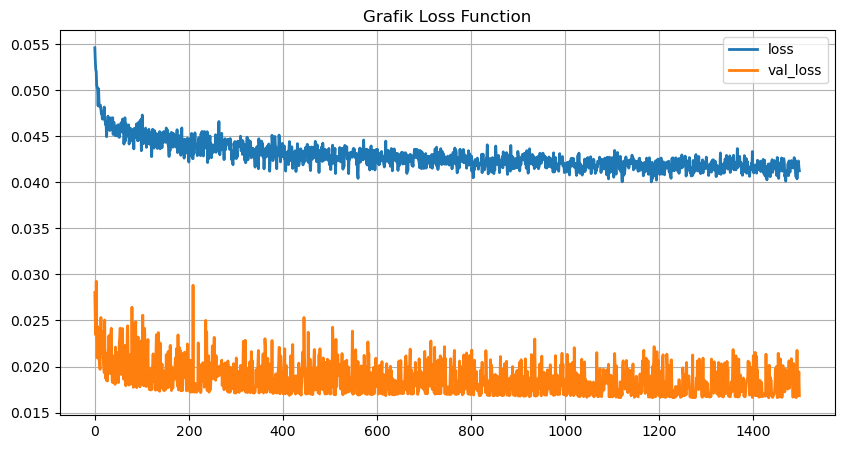

In [32]:
# show plot loss function
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="loss", linewidth=2)
ax.plot(history.history['val_loss'], color="tab:orange", label="val_loss", linewidth=2)

# membuat label-label
ax.set_title("Grafik Loss Function")
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [33]:
# 5. make predictions
predictions = model.predict(x_test, verbose=0)
print(predictions[:, 0])

[0.00084994 0.00082184 0.0009623  0.00100445 0.00190852 0.00133159
 0.00306682 0.02945727 0.12255636 0.11733097 0.05974451 0.00134659
 0.00108872 0.00104658 0.00157057 0.00158811 0.00108872 0.00104658
 0.00111681 0.00168825 0.00111681 0.00127163 0.00113085 0.00082184
 0.00079375 0.00079375 0.00092017 0.00162667 0.00153551 0.00162667
 0.00323324 0.00236815 0.00218859 0.00143653 0.0009904  0.00103254
 0.00079375 0.00087804 0.00128663 0.00090612 0.00131661 0.00113085
 0.00166773 0.0020719  0.00127163 0.00092017 0.00084994 0.00086398
 0.00075161 0.00086398 0.00087804 0.00120109 0.00139157 0.00142154
 0.00151846 0.00572111 0.07496759 0.09987386 0.01374107]


### 6. Evaluasi Model

In [34]:
mae = mean_absolute_error(y_test, predictions) * 100
print('Test MAE : %.4f' % mae)

Test MAE : 1.6822


In [35]:
mse = mean_squared_error(y_test, predictions) * 100
print('Test MSE: %.4f' % mse)

Test MSE: 0.2512


In [36]:
mape = mean_absolute_percentage_error(y_test, predictions) * 100
print('Test MAPE: %.2f' % mape)

Test MAPE: 6594981429914.17


In [37]:
hasil = np.stack((y_test.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,0.000346,0.000850
1,0.001039,0.000822
2,0.001247,0.000962
3,0.004988,0.001004
4,0.002841,0.001909


In [38]:
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.6515 dengan signifikansi 0.0000 


- Kompleksitas waktu  

In [39]:
# Set akhir waktu komputasi 
end = tm.time()

In [40]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [41]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:06:33.19


### 7. Visualisasi Data

In [42]:
if algorithm == "LSTM-RNN":
    title = "Model Stacked-Bidirectional LSTM-RNN"
else:
    title = "Model Stacked-Bidirectional GRU-RNN"

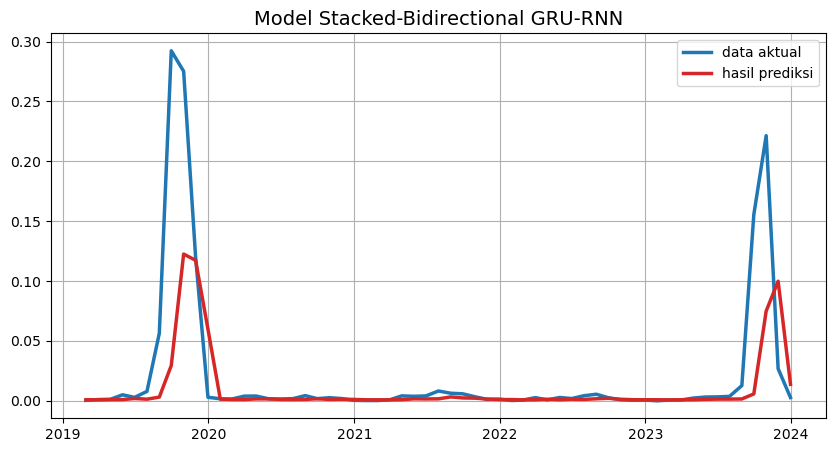

In [43]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
ax.set_title(title, fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)
plt.show()

### 8. Hasil Prediksi Titik Panas

In [44]:
# inverse value test predictions
testPredictions = scaler.inverse_transform(predictions)
testActual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [45]:
x = pd.DataFrame(np.array(dataset.iloc[train_size+1:len(dataset),0]), columns=['Date'])
y = pd.DataFrame(testActual, columns=['Data Aktual'])
z = pd.DataFrame(testPredictions, columns=['Data Prediksi'])

In [46]:
hasil_prediksi = pd.concat([x, y, z], axis=1)

In [47]:
hasil_prediksi = np.round(hasil_prediksi, 0)

In [48]:
if algorithm == "LSTM-RNN":
    hasil_prediksi.to_csv("hasil_prediksi_m1.csv", index=False)
else:
    hasil_prediksi.to_csv("hasil_prediksi_m4.csv", index=False)

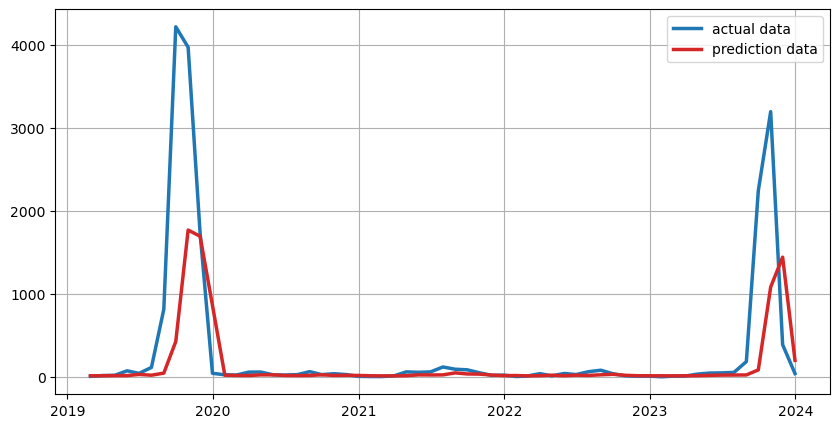

In [49]:
fix, ax = plt.subplots(figsize=(10,5))

ax.plot(hasil_prediksi["Date"], hasil_prediksi["Data Aktual"], color="tab:blue", label="actual data", linewidth=2.5)
ax.plot(hasil_prediksi["Date"], hasil_prediksi["Data Prediksi"], color="tab:red", label="prediction data", linewidth=2.5)

# Mengatur format tanggal ke format tahun
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# membuat label-label
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [50]:
hasil_prediksi

,Date,Data Aktual,Data Prediksi
0,2019-02-28,8.0,15.0
1,2019-03-31,18.0,15.0
2,2019-04-30,21.0,17.0
3,2019-05-31,75.0,17.0
4,2019-06-30,44.0,31.0
5,2019-07-31,116.0,22.0
6,2019-08-31,817.0,47.0
7,2019-09-30,4223.0,428.0
8,2019-10-31,3976.0,1772.0
9,2019-11-30,1736.0,1697.0
